In [2]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import interpolate
import sys
sys.path.append('../src')
from noise_generation import noise_generation
from noise_generation import linear_interpolation
from noise_generation import temporal_autocorrelation

In [3]:
seed = 1
ar_id = 202200018

# Get the current working directory (where your Jupyter Notebook is located)
notebook_dir = os.getcwd()
# Construct the relative path to the data directory
cesm_rainstorm_folder = os.path.join(notebook_dir, "../data/cesm2/cesm2_rainstorm_covariates")
match_aorc_rainfall_folder = os.path.join(notebook_dir, "../data/cesm2/matched_aorc_rainfall")

# load precipitation data
raw_cesm_prcp_xarray = xr.load_dataset(cesm_rainstorm_folder + "/" + "{0}_prect_cesm_res.nc".format(ar_id))
raw_cesm_prcp_array = raw_cesm_prcp_xarray['prect'].data

# load precipitation data
aorc_array = np.load(match_aorc_rainfall_folder + "/" + "{0}_sr_rainfall.npy".format(ar_id))
# load wind data
u_xarray = xr.load_dataset(cesm_rainstorm_folder + "/" + "{0}_u850_cesm_res.nc".format(ar_id))
v_xarray = xr.load_dataset(cesm_rainstorm_folder + "/" + "{0}_v850_cesm_res.nc".format(ar_id))

# get numpy array
time_steps = u_xarray['time'].data
# aorc_array = aorc_xarray['aorc'].data
coarse_u_array = u_xarray['u850'].data
coarse_v_array = v_xarray['v850'].data

u_array = np.zeros((coarse_u_array.shape[0], 630, 1024))
v_array = np.zeros((coarse_v_array.shape[0], 630, 1024))

# set up AORC coordinates
aorc_lat = np.linspace(50, 29, 630)
aorc_lon = np.linspace(-113.16734, -79.068704, 1024)

cesm_lat = np.linspace(50.41884817, 28.7434555, 24)
cesm_lon = np.linspace(-113.75, -78.75, 29)


In [4]:
# interpolate to AORC resolution
for time_index in range(coarse_u_array.shape[0]):
    curr_coarse_u_array = coarse_u_array[time_index]
    curr_coarse_v_array = coarse_v_array[time_index]

    u_array[time_index] = linear_interpolation(curr_coarse_u_array, cesm_lon, cesm_lat, aorc_lon, aorc_lat)
    v_array[time_index] = linear_interpolation(curr_coarse_v_array, cesm_lon, cesm_lat, aorc_lon, aorc_lat)

## Calculate lag-1 auto-correlation 
```
Function: temporal_autocorrelation(prcp_array)
```
Parameters:
- **prcp_array**(numpy.ndarray): Array of precipitation fields used to compute lag-1 autocorrelation at each time step. The precipitation array has a dimension of (time, lat, lon) with a unit of mm. The lag-1 autocorrelation is computed as the correlation coefficient between two precipitation fields at consecutive time steps. The autocorrelation at the first time step is set to 0.5.

Returns:
- **auto_corr_list**(numpy.ndarray): Array of lag-1 autocorrelation coefficients with dimension of (time, ). 

In [5]:
# calculate the correlation
auto_corr_list = temporal_autocorrelation(prcp_array=raw_cesm_prcp_array)

## Generate noise fields
```
Function: noise_generation(prcp_array, auto_corr_list, u_array, v_array, lon_data, lat_data, window_size,
                     overlap_ratio, ssft_war_thr, seed)
```
Parameters:
- **prcp_array** (numpy.ndarray): Array of high-resolution precipitation fields used to generate noise fields. The precipitation array has a dimension of (time, lat, lon) with a unit of mm.  
- **auto_corr_list** (numpy.ndarray): Array of lag-1 autocorrelation coefficients with dimension of (time, ). 
- **u_array** (numpy.ndarray): Array of high-resolution east-west wind velocity fields used for noise advection. The noise array has a dimension of (time, lat, lon) with a unit of m/6-hour. 
- **v_array** (numpy.ndarray): Array of high-resolution north-south wind velocity fields used for noise advection. The noise array has a dimension of (time, lat, lon) with a unit of m/6-hour. It is recommended to set them to 0 if the time scale is greater 6 hours. 
- **lon_data** (numpy.ndarray): Longitude coordinates of the precipitation fields. 
- **lat_data** (numpy.ndarray): Latitude coordinates of the precipitation fields. 
- **window_size** (float): Window size of local Fast Fourier Transform. Default is (128, 128). 
- **overlap_ratio** (float): Overlap ratio of each local FFT window. Default is 0.3. 
- **ssft_war_thr** (float): Threshold of precipitation area ratio to perform local FFT. Default is 0.1.  
- **seed** (integer): Random Seed. 

Returns:
- **final_noise_array** (numpy.ndarray): Array of high-resolution noise fields generated from input precipitation fields. The noise fields inherit the spatio-temporal structures of the original precipitation fields. 


In [6]:
# set up AORC coordinates
aorc_lat = np.linspace(50, 29, 630)
aorc_lon = np.linspace(-113.16734, -79.068704, 1024)
window_size = (128, 128)
window_function = 'tukey'
overlap_ratio = 0.3
ssft_war_thr = 0.1

# generate a copy
sub_ar_prcp_field_copy = np.where(aorc_array < 0.2, 0, aorc_array)

final_prcp_noise_array = noise_generation(sub_ar_prcp_field_copy, auto_corr_list, u_array*3600*6, v_array*3600*6, aorc_lon, aorc_lat, window_size,
                 overlap_ratio, ssft_war_thr, seed)

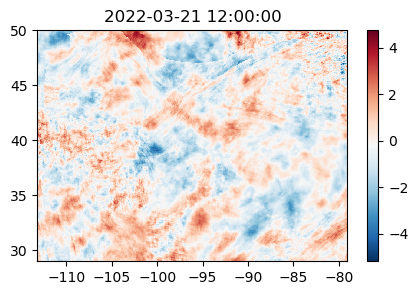

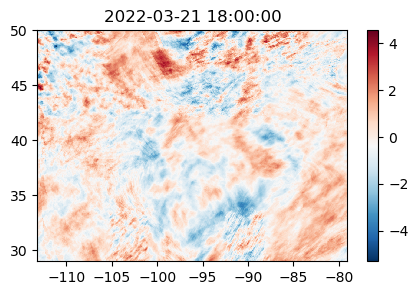

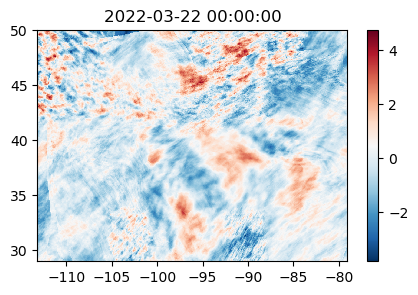

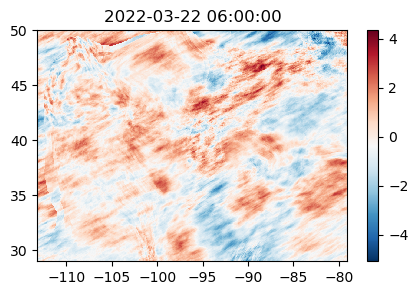

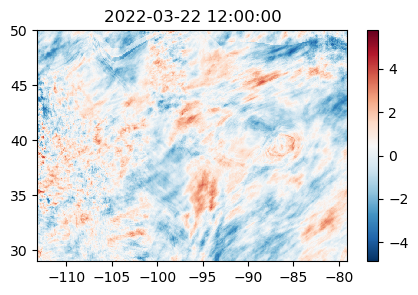

In [13]:
for time_index in np.arange(5, 10): 
    plt.figure(figsize = (5, 3))
    plt.title(time_steps[time_index])
    plt.pcolormesh(aorc_lon, aorc_lat, final_prcp_noise_array[time_index], cmap = 'RdBu_r')
    plt.colorbar()